<font color='red'  size=7>Fuzzy Project</font>

<font   size=6> [1] : Problem Statement</font> 

## القيام ببناء نظام خبير لتشخيص مرض المريض بناءً على  الأعراض والعمر والتاريخ الطبي


## تشخيص مرض السكري



### Prepare libraries and data

In [2]:
from tkinter import *
from tkinter import messagebox as mb
import json

import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

import pandas as pd

<font   size=6> [2] : Fuzzy Sets</font> 

## Input :  symptoms, age, and medical history

In [3]:
glucose = ctrl.Antecedent(np.arange(56, 199, 0.01), 'glucose') #تركيز جلوكوز
age = ctrl.Antecedent(np.arange(21, 82, 0.01), 'age') #العمر
pedi= ctrl.Antecedent(np.arange(0 ,2.42,0.01), 'pedi') #  تاريخ مرض سكري مرتبط بشخص معين 
bmi = ctrl.Antecedent(np.arange(18.2, 67.2, 0.01), 'bmi') #  =  (weight in kg/(height in m)2)كتلة الجسم

## Output : Disease

In [4]:
prediction = ctrl.Consequent(np.arange(0, 1.05, 0.05), 'prediction',
                             defuzzify_method="centroid")

<font   size=6> [3] : Membership Functions</font> 

In [5]:
def glucoseTri(glucose: ctrl.Antecedent):
    glucose['very low'] = fuzz.trapmf(glucose.universe, [0, 53, 61.5, 97.5])
    glucose['low'] = fuzz.trimf(glucose.universe, [53, 83.75, 125])
    glucose['medium'] = fuzz.trimf(glucose.universe, [70, 111.25, 162.5])
    glucose['high'] = fuzz.trimf(glucose.universe, [97.5, 143.75, 200])
    glucose['very high'] = fuzz.trapmf(glucose.universe, [125, 181.25, 200, 300])


def ageTrap(age: ctrl.Antecedent):
    age['young'] = fuzz.trapmf(age.universe, [0, 19, 21, 32.5])
    age['middle age'] = fuzz.trapmf(age.universe, [20, 27.25, 37.75, 47])
    age['old'] = fuzz.trapmf(age.universe, [32.5, 45, 49, 66.5])
    age['very old'] = fuzz.trapmf(age.universe, [47, 58.75, 100, 100])



def bmiTri(bmi: ctrl.Antecedent):
    bmi['underweight'] = fuzz.trapmf(bmi.universe, [0, 0, 18.25, 21.75])
    bmi['normal weight'] = fuzz.trimf(bmi.universe, [18.25, 21.75, 27.5])
    bmi['overweight'] = fuzz.trimf(bmi.universe, [21.75, 27.5, 32.5])
    bmi['obesity 1'] = fuzz.trimf(bmi.universe, [27.5, 32.5, 37.5])
    bmi['obesity 2'] = fuzz.trimf(bmi.universe, [32.5, 37.5, 42.5])
    bmi['obesity 3'] = fuzz.trapmf(bmi.universe, [37.5, 42.5, 80, 80])


    
def pedigreeTri(pedi: ctrl.Antecedent):
    pedi['Low'] = fuzz.trimf(pedi.universe, [0 ,0, 0.8032])
    pedi['Medium'] = fuzz.trimf(pedi.universe, [0.1405, 0.8032 ,1.612])
    pedi['High'] = fuzz.trimf(pedi.universe, [0.8032 ,1.612 ,2.42])

    
    
def predictionTri(prediction: ctrl.Consequent):
    prediction['no'] = fuzz.trimf(prediction.universe, [0, 0, 0.8])
    prediction['yes'] = fuzz.trimf(prediction.universe, [0.2, 1, 1])
    

pedigreeTri(pedi=pedi)
glucoseTri(glucose=glucose)
ageTrap(age=age)
bmiTri(bmi=bmi)
predictionTri(prediction=prediction)

## The view methods

C:\Users\HP\anaconda3\envs\Vision\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


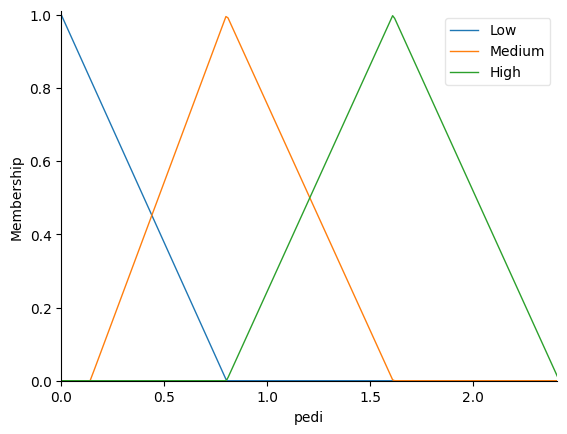

In [6]:
pedi.view()

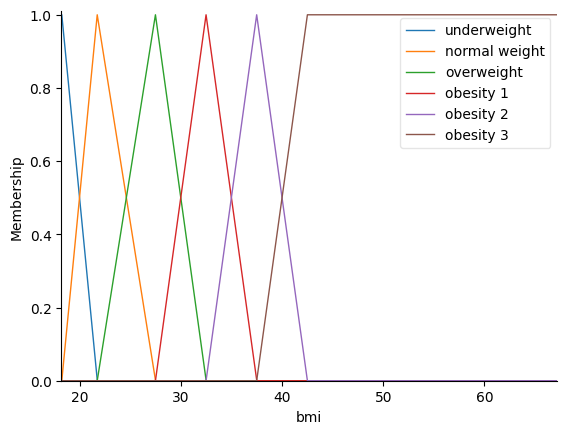

In [7]:
bmi.view()

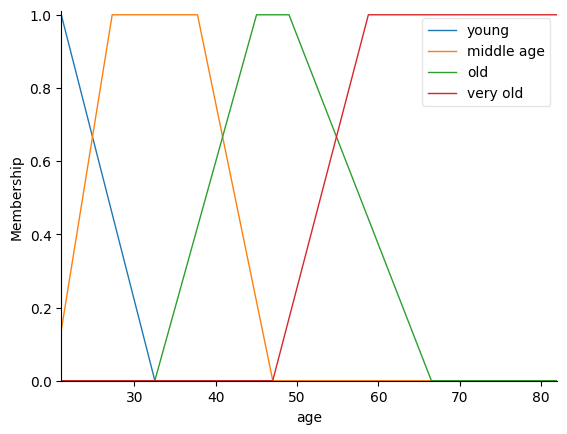

In [8]:
age.view()

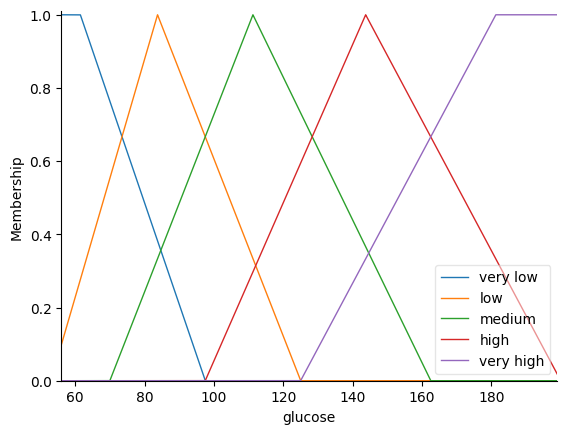

In [9]:
glucose.view()

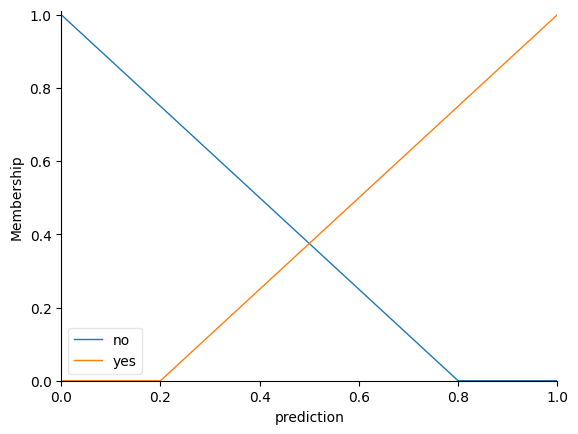

In [10]:
prediction.view()

<font   size=6> [4] : Rule Base</font> 

In [11]:
def buildRules(glucose: ctrl.Antecedent,age: ctrl.Antecedent,bmi: ctrl.Antecedent,prediction: ctrl.Consequent,pedi:ctrl.Antecedent):
    return [
        # glucose, age,pedi ,no
        ctrl.Rule( ( glucose['very low'] &
                  (age['young'] | age['middle age'] | age['old']) )  | (pedi['Low'] | pedi['Medium'])  ,
                  prediction['no']),
        ctrl.Rule((glucose['low'] &
                  (age['young'] | age['middle age']) )| (pedi['Low'] | pedi['Medium']) ,
                  prediction['no']),
        ctrl.Rule((glucose['medium'] &
                  (age['young'] | age['middle age']) )| (pedi['Low'] | pedi['Medium'])  ,
                  prediction['no']),
        ctrl.Rule( ( glucose['high'] &
                  age['young'] ) | (pedi['Low'] | pedi['Medium'] ),
                  prediction['no']),

        # glucose, age,pedi , yes
        ctrl.Rule((glucose['high'] &
                  age['old']  ) |  (pedi['High']) ,
                  prediction['yes'] ),
        ctrl.Rule( ( glucose['very high'] &
                  (age['young'] | age['middle age'] | age['very old']) )  | (pedi['High']) ,
                  prediction['yes']),

        # glucose, bmi, no
        ctrl.Rule( ( glucose['very low'] &
                  (bmi['normal weight'] | bmi['overweight'] | bmi['obesity 2']) )  ,
                  prediction['no']),
        ctrl.Rule( ( glucose['low'] &
                  (bmi['underweight'] | bmi['normal weight'] | bmi['overweight'] | bmi['obesity 1'] | bmi['obesity 2'] ) ),
                  prediction['no']),
        ctrl.Rule((glucose['medium'] &
                  (bmi['normal weight'] | bmi['overweight'] | bmi['obesity 2']) ) ,
                  prediction['no']),
        ctrl.Rule((glucose['high'] &
                  (bmi['normal weight']) ),
                  prediction['no']),

        # glucose, bmi,pedi , yes
        ctrl.Rule((glucose['very high'] &
                  (bmi['normal weight'] | bmi['overweight'] | bmi['obesity 1'] | bmi['obesity 2']) )| (pedi['High'] ),
                  prediction['yes']),
        
        
        
    ]



rules = buildRules(
    glucose=glucose,
    age=age,
    bmi=bmi,
    prediction=prediction,
    pedi=pedi
)



(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

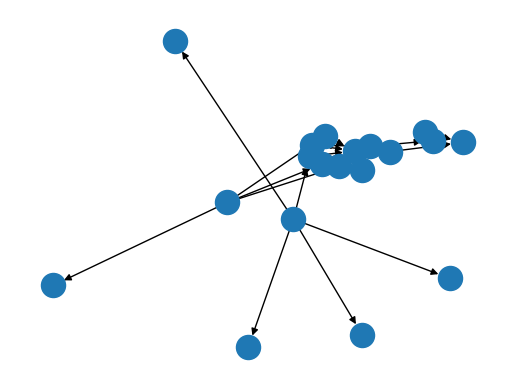

In [12]:
rule1=ctrl.Rule(( glucose['very low'] &
                  (age['young'] | age['middle age'] | age['old']) )  | (pedi['Low'] | pedi['Medium'])  ,
                  prediction['no'])
rule1.view()

<font   size=6> [5] :Inference Engine</font> 

In [13]:
prediction_ctrl = ctrl.ControlSystem(rules)
prediction_inference = ctrl.ControlSystemSimulation(prediction_ctrl)

prediction_inference.input['glucose'] = 180.0
prediction_inference.input['age'] = 27.0
prediction_inference.input['bmi'] = 37.99
prediction_inference.input['pedi'] = 0

prediction_inference.compute()
result_np = prediction_inference.output['prediction']

print(result_np)

output_np = np.where(result_np > 0.50, 'yes (diabetic)', 'no (non-diabetic)')
print(output_np)

0.49966021791907855
no (non-diabetic)


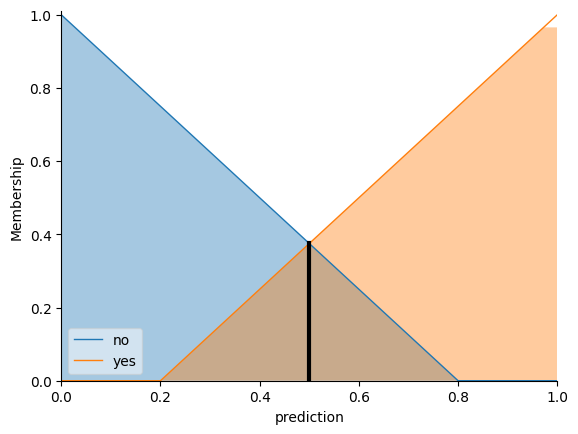

In [14]:
prediction.view(sim=prediction_inference)

<font   size=6> [6] :Deffuzication</font> 

80.36 حيث أعطى أعلى دقة   centroid  تم تجربة عدة توابع واعتماد تابع

<font   size=6> [7] :User Interface</font> 

In [15]:
def output_prediction(glucose_input,age_input,bmi_input,pedi_input):
    
    prediction_inference.input['glucose'] = glucose_input
    prediction_inference.input['age'] = age_input
    prediction_inference.input['bmi'] = bmi_input
    prediction_inference.input['pedi'] = pedi_input


    prediction_inference.compute()

    confidence_value = prediction_inference.output['prediction']

    x=prediction.view(sim=prediction_inference)
    
    return confidence_value,x

bmi is 0
0.5604488543819001


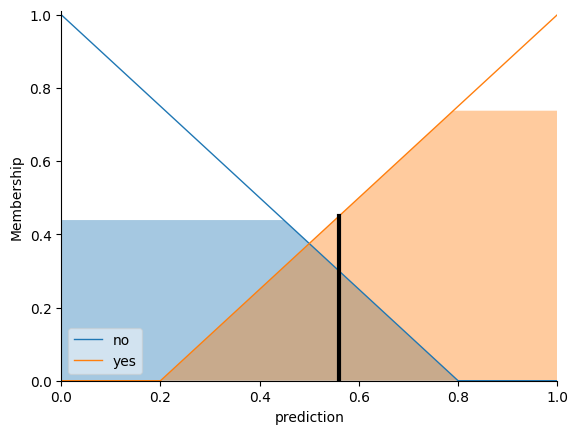

In [16]:
import sys
from tkinter import *
import tkinter.ttk as ttk
from PIL import Image, ImageTk
import threading

def vp_start_gui():
    global val, w, root
    root = Tk()
    top = New_Toplevel_1 (root)
    root.mainloop()

w = None
def create_New_Toplevel_1(root, *args, **kwargs):
    global w, w_win, rt
    rt = root
    w = Toplevel (root)
    top = New_Toplevel_1 (w)
    return (w, top)

def destroy_New_Toplevel_1():
    global w
    w.destroy()
    w = None

class New_Toplevel_1:
    def __init__(self, top=None):
        '''This class configures and populates the toplevel window.
           top is the toplevel containing window.'''
        _bgcolor = 'steel blue'  
        _fgcolor = '#000000' 
        _compcolor = '#d9d9d9' 
        _ana1color = '#d9d9d9' 
        _ana2color = '#d9d9d9' 
        font11 = "-family Arial -size 19 -weight normal -slant roman "  \
            "-underline 0 -overstrike 0"
        font12 = "-family Arial -size 12 -weight normal -slant roman "  \
            "-underline 0 -overstrike 0"
        font14 = "-family Arial -size 15 -weight normal -slant roman "  \
            "-underline 0 -overstrike 0"
        font15 = "-family Arial -size 12 -weight bold -slant roman "  \
            "-underline 0 -overstrike 0"
        self.style = ttk.Style()
        if sys.platform == "win32":
            self.style.theme_use('winnative')
        self.style.configure('.',background=_bgcolor)
        self.style.configure('.',foreground=_fgcolor)
        self.style.configure('.',font="TkDefaultFont")
        self.style.map('.',background=
            [('selected', _compcolor), ('active',_ana2color)])

        top.geometry("968x493+919+245")
        top.title("Diabetes Detection Fuzzy System")
        top.configure(background="#d9d9d9")
        top.configure(highlightbackground="#b9b9b9")
        top.configure(highlightcolor="black")

        self.TFrame1 = ttk.Frame(top)
        self.TFrame1.place(relx=0.01, rely=0.02, relheight=0.94, relwidth=0.48)
        self.TFrame1.configure(relief=GROOVE)
        self.TFrame1.configure(borderwidth="2")
        self.TFrame1.configure(relief=GROOVE)
        self.TFrame1.configure(width=465)

        self.TLabel1 = ttk.Label(self.TFrame1)
        self.TLabel1.place(relx=0.2, rely=0.04, height=32, width=350)
        self.TLabel1.configure(background=_bgcolor)
        self.TLabel1.configure(foreground="#000000")
        self.TLabel1.configure(font=font11)
        self.TLabel1.configure(relief=FLAT)
        self.TLabel1.configure(text='''Enter Patient's data ''')

#-----------------------------------glucose----------------------------------------
        self.TLabel3 = ttk.Label(self.TFrame1)
        self.TLabel3.place(relx=0.04, rely=0.53, height=39, width=120)
        self.TLabel3.configure(background=_bgcolor)
        self.TLabel3.configure(foreground="#000000")
        self.TLabel3.configure(font=font12)
        self.TLabel3.configure(relief=FLAT)
        self.TLabel3.configure(text='''Glucose''')

        self.TEntry_Plas = ttk.Entry(self.TFrame1)
        self.TEntry_Plas.place(relx=0.24, rely=0.53, relheight=0.05
                , relwidth=0.53)
        self.TEntry_Plas.configure(width=246)
        self.TEntry_Plas.configure(takefocus="")
        self.TEntry_Plas.configure(cursor="ibeam")


#----------------------------------------Weight----------------------------------

        self.TLabel5 = ttk.Label(self.TFrame1)
        self.TLabel5.place(relx=0.04, rely=0.43, height=39, width=120)
        self.TLabel5.configure(background=_bgcolor)
        self.TLabel5.configure(foreground="#000000")
        self.TLabel5.configure(font=font12)
        self.TLabel5.configure(relief=FLAT)
        self.TLabel5.configure(text='''Weight''')

        self.TEntry_weight = ttk.Entry(self.TFrame1)
        self.TEntry_weight.place(relx=0.24, rely=0.43, relheight=0.05
                , relwidth=0.53)
        self.TEntry_weight.configure(width=246)
        self.TEntry_weight.configure(takefocus="")
        self.TEntry_weight.configure(cursor="ibeam")

#-----------------------------height-----------------------------------------

        self.TLabel6 = ttk.Label(self.TFrame1)
        self.TLabel6.place(relx=0.04, rely=0.33, height=39, width=120)
        self.TLabel6.configure(background=_bgcolor)
        self.TLabel6.configure(foreground="#000000")
        self.TLabel6.configure(font=font12)
        self.TLabel6.configure(relief=FLAT)
        self.TLabel6.configure(text='''height''')

        self.TEntry_height = ttk.Entry(self.TFrame1)
        self.TEntry_height.place(relx=0.24, rely=0.33, relheight=0.05
                , relwidth=0.53)
        self.TEntry_height.configure(width=246)
        self.TEntry_height.configure(takefocus="")
        self.TEntry_height.configure(cursor="ibeam")

#-----------------------------BMI Value--------------------------------------

        self.TLabel4 = ttk.Label(self.TFrame1)
        self.TLabel4.place(relx=0.04, rely=0.23, height=39, width=120)
        self.TLabel4.configure(background=_bgcolor)
        self.TLabel4.configure(foreground="#000000")
        self.TLabel4.configure(font=font12)
        self.TLabel4.configure(relief=FLAT)
        self.TLabel4.configure(text='''BMI Value''')

        self.TEntry_bmi = ttk.Entry(self.TFrame1)
        self.TEntry_bmi.place(relx=0.24, rely=0.23, relheight=0.05
                , relwidth=0.53)
        self.TEntry_bmi.configure(width=246)
        self.TEntry_bmi.configure(takefocus="")
        self.TEntry_bmi.configure(cursor="ibeam")

#-----------------------------Pedigree------------------------------------

        self.TLabel6 = ttk.Label(self.TFrame1)
        self.TLabel6.place(relx=0.04, rely=0.72, height=39, width=120)
        self.TLabel6.configure(background=_bgcolor)
        self.TLabel6.configure(foreground="#000000")
        self.TLabel6.configure(font=font12)
        self.TLabel6.configure(relief=FLAT)
        self.TLabel6.configure(text='''Pedigree''')

        self.TEntry_Pedigree = ttk.Entry(self.TFrame1)
        self.TEntry_Pedigree.place(relx=0.24, rely=0.72, relheight=0.05
                              , relwidth=0.53)
        self.TEntry_Pedigree.configure(width=246)
        self.TEntry_Pedigree.configure(takefocus="")
        self.TEntry_Pedigree.configure(cursor="ibeam")

#-----------------------------Age-----------------------------------------

        self.TLabel6 = ttk.Label(self.TFrame1)
        self.TLabel6.place(relx=0.04, rely=0.63, height=39, width=120)
        self.TLabel6.configure(background=_bgcolor)
        self.TLabel6.configure(foreground="#000000")
        self.TLabel6.configure(font=font12)
        self.TLabel6.configure(relief=FLAT)
        self.TLabel6.configure(text='''Age''')

        self.TEntry_Age = ttk.Entry(self.TFrame1)
        self.TEntry_Age.place(relx=0.24, rely=0.63, relheight=0.05
                              , relwidth=0.53)
        self.TEntry_Age.configure(width=246)
        self.TEntry_Age.configure(takefocus="")
        self.TEntry_Age.configure(cursor="ibeam")
# -----------------------------------------------------------------------

        self.TButton_eval = ttk.Button(self.TFrame1)
        self.TButton_eval.place(relx=0.34, rely=0.90, height=35, width=126)
        self.TButton_eval.configure(takefocus="")
        self.TButton_eval.configure(text='''Evaluate''')
        self.TButton_eval.bind('<Button-1>',lambda e:main_support.TButton_eval_onClick(e))


        self.TLabel_Indicator = ttk.Label(self.TFrame1)
        self.TLabel_Indicator.place(relx=0.29, rely=0.80, height=19, width=184)
        self.TLabel_Indicator.configure(background=_bgcolor)
        self.TLabel_Indicator.configure(foreground="#000000")
        self.TLabel_Indicator.configure(relief=FLAT)
        self.TLabel_Indicator.configure(anchor=CENTER)


        #bmi
        self.TLabel11 = ttk.Label(self.TFrame1)
        self.TLabel11.place(relx=0.8, rely=0.24, height=19, width=76)
        self.TLabel11.configure(background=_bgcolor)
        self.TLabel11.configure(foreground="#000000")
        self.TLabel11.configure(font=font15)
        self.TLabel11.configure(relief=FLAT)
        self.TLabel11.configure(anchor=W)
        self.TLabel11.configure(text='''0-80''')
        self.TLabel11.configure(width=76)
    
        #hieght
        self.TLabel11 = ttk.Label(self.TFrame1)
        self.TLabel11.place(relx=0.8, rely=0.45, height=19, width=76)
        self.TLabel11.configure(background=_bgcolor)
        self.TLabel11.configure(foreground="#000000")
        self.TLabel11.configure(font=font15)
        self.TLabel11.configure(relief=FLAT)
        self.TLabel11.configure(anchor=W)
        self.TLabel11.configure(text='''40-150''')
        self.TLabel11.configure(width=76)

        #wieght
        self.TLabel10 = ttk.Label(self.TFrame1)
        self.TLabel10.place(relx=0.8, rely=0.34, height=19, width=70)
        self.TLabel10.configure(background=_bgcolor)
        self.TLabel10.configure(foreground="#000000")
        self.TLabel10.configure(font=font15)
        self.TLabel10.configure(relief=FLAT)
        self.TLabel10.configure(anchor=W)
        self.TLabel10.configure(text='''100-230''')
        self.TLabel10.configure(width=56)

        #glucose
        self.TLabel10 = ttk.Label(self.TFrame1)
        self.TLabel10.place(relx=0.8, rely=0.55, height=19, width=56)
        self.TLabel10.configure(background=_bgcolor)
        self.TLabel10.configure(foreground="#000000")
        self.TLabel10.configure(font=font15)
        self.TLabel10.configure(relief=FLAT)
        self.TLabel10.configure(anchor=W)
        self.TLabel10.configure(text='''0-200''')
        self.TLabel10.configure(width=56)

        #pedi
        self.TLabel10 = ttk.Label(self.TFrame1)
        self.TLabel10.place(relx=0.8, rely=0.74, height=19, width=56)
        self.TLabel10.configure(background=_bgcolor)
        self.TLabel10.configure(foreground="#000000")
        self.TLabel10.configure(font=font15)
        self.TLabel10.configure(relief=FLAT)
        self.TLabel10.configure(anchor=W)
        self.TLabel10.configure(text='''0-2.42''')
        self.TLabel10.configure(width=56)

        #age
        self.TLabel10 = ttk.Label(self.TFrame1)
        self.TLabel10.place(relx=0.8, rely=0.64, height=19, width=56)
        self.TLabel10.configure(background=_bgcolor)
        self.TLabel10.configure(foreground="#000000")
        self.TLabel10.configure(font=font15)
        self.TLabel10.configure(relief=FLAT)
        self.TLabel10.configure(anchor=W)
        self.TLabel10.configure(text='''20-80''')
        self.TLabel10.configure(width=56)

        self.TLabel_Output = ttk.Label(top)
        self.TLabel_Output.place(relx=0.52, rely=0.06, height=29, width=436)
        self.TLabel_Output.configure(background="#d9d9d9")
        self.TLabel_Output.configure(foreground="#000000")
        self.TLabel_Output.configure(font=font11)
        self.TLabel_Output.configure(relief=FLAT)
        self.TLabel_Output.configure(anchor=CENTER)
        self.TLabel_Output.configure(text='''Diabetes Stage :''')
        self.TLabel_Output.configure(width=436)

        self.Canvas_Graph = Canvas(top)
        self.Canvas_Graph.place(relx=0.51, rely=0.16, relheight=0.66
                , relwidth=0.47)
        self.Canvas_Graph.configure(background="white")
        self.Canvas_Graph.configure(borderwidth="2")
        self.Canvas_Graph.configure(highlightbackground="#e0ded1")
        self.Canvas_Graph.configure(highlightcolor="black")
        self.Canvas_Graph.configure(insertbackground="black")
        self.Canvas_Graph.configure(relief=RIDGE)
        self.Canvas_Graph.configure(selectbackground="#cac8bc")
        self.Canvas_Graph.configure(selectforeground="black")
        self.Canvas_Graph.configure(width=456)

        self.TLabel_OutputText = ttk.Label(top)
        self.TLabel_OutputText.place(relx=0.52, rely=0.87, height=29, width=500)
        self.TLabel_OutputText.configure(background="#d9d9d9")
        self.TLabel_OutputText.configure(foreground="#000000")
        self.TLabel_OutputText.configure(font=font14)
        self.TLabel_OutputText.configure(relief=FLAT)
        self.TLabel_OutputText.configure(anchor=CENTER)
        self.TLabel_OutputText.configure(width=500)

        widgets = [self.TEntry_Plas,  self.TEntry_weight, self.TEntry_height,self.TEntry_Pedigree,self.TEntry_Age,self.TEntry_bmi]
        self.TButton_eval.bind('<Button-1>',lambda e:self.TButton_eval_onClick(e, widgets))

        self.TEntry_Plas.insert(END, '140')
        self.TEntry_weight.insert(END, '50')
        self.TEntry_height.insert(END, '160')
        self.TEntry_Pedigree.insert(END, '1.40')
        self.TEntry_Age.insert(END, '30')
        self.TEntry_bmi.insert(END, '0')


    def TButton_eval_onClick(self, p1, widgets):

        self.TLabel_Indicator['text'] = "Processing"
        self.TButton_eval.state(['disabled'])
        args = [float(x.get()) for x in widgets]
        t = threading.Thread(target=self.doMATLABProcessing, args=[args])
        t.daemon = True
        t.start()

    def doMATLABProcessing(self, data):
        if data[5]==0:
            print("bmi is 0")
            p=pow((data[2]/100),2)
            bmi=data[1]/p
            bmi=round(bmi,2)
            
        else :
            bmi=data[5]
            
        val,x=output_prediction(data[0],data[4],bmi,data[3])
        print(val)


        self.tk_img = ImageTk.PhotoImage(file='output.jpg')

        self.Canvas_Graph.create_image(410, 250, image=self.tk_img)
        self.TLabel_Output['text'] = "Output : %.5f" % val
        self.TLabel_Indicator['text'] = "Done!"
        
        
        self.outputOutputMsg(val)

        # enable the button back
        self.TButton_eval.state(['!disabled'])

    def outputOutputMsg(self, val):
        cond = []
        if val >= 0.1 and val <= 0.9: cond += ['medium']
        if val >= 0 and val <= 0.4: cond += ['safe']
        if val >= 0.6 and val <= 1.0: cond += ['dangerous']
        if len(cond) == 1:
            if val <= 0.1:
                self.TLabel_OutputText['text'] = "You're in safe stage of Diabetes.".format(*cond)
            if val >= 0.4 and val <= 0.6:
                self.TLabel_OutputText['text'] = "You're in Medium stage of Diabetes.".format(*cond)
            if val >= 0.7:
                self.TLabel_OutputText['text'] = "You're in dangerous stage of Diabetes.".format(*cond)

        else:
            if val >= 0.1 and val <= 0.4:
                self.TLabel_OutputText['text'] = "You're in Medium and safe stage of Diabetes.".format(*cond)
            if val >= 0.6 and val <= 0.7:
                self.TLabel_OutputText['text'] = "You're in Medium and Dangerous stage of Diabetes.".format(*cond)


if __name__ == '__main__':
    vp_start_gui()


<font   size=6> [8] :Testing and Validation</font> 

## Data 

In [17]:
data_df=pd.read_csv('data/diabetes.csv')
data_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [18]:
clean_data_df = data_df[
    (data_df['Glucose'] != 0) &
    (data_df['BloodPressure'] != 0) &
    (data_df['SkinThickness'] != 0) &
    (data_df['Insulin'] != 0) &
    (data_df['BMI'] != 0)
]
clean_data_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
13,1,189,60,23,846,30.1,0.398,59,1
...,...,...,...,...,...,...,...,...,...
753,0,181,88,44,510,43.3,0.222,26,1
755,1,128,88,39,110,36.5,1.057,37,1
760,2,88,58,26,16,28.4,0.766,22,0
763,10,101,76,48,180,32.9,0.171,63,0


In [19]:
output_np = np.where(result_np > 0.50, 1, 0)
gt_np = clean_data_df['Outcome'].to_numpy()
total_sample = gt_np.shape[0]
accurate_sample = (output_np == gt_np).sum()
accuracy = (accurate_sample / total_sample) * 100
print(total_sample)
print(accurate_sample)
print(f"{accuracy:.2f}") 

392
262
66.84


In [20]:
rnd = np.random.default_rng(seed=4242)
selected_indices = rnd.integers(low=0, high=clean_data_df.shape[0], size=5).tolist()
print(selected_indices)
prediction_ctrl = ctrl.ControlSystem(rules)
prediction_inference = ctrl.ControlSystemSimulation(prediction_ctrl)

test_run_result_dict = {
    "Glucose": [],
    "BMI": [],
    "Age": [],
    'Pedi':[],
    "Prediction": [],
    "Risk": [],
    "Ground Truth": []
}

for ind in selected_indices:
    selected_series = clean_data_df.iloc[ind]
    glucose_input = selected_series['Glucose']
    bmi_input = selected_series['BMI']
    age_input = selected_series['Age']
    pedi_input = selected_series['DiabetesPedigreeFunction']
    prediction_gt = selected_series['Outcome']


    prediction_inference.input['glucose'] = glucose_input
    prediction_inference.input['age'] = age_input
    prediction_inference.input['bmi'] = bmi_input
    prediction_inference.input['pedi'] = pedi_input


    prediction_inference.compute()
    prediction_confidence = prediction_inference.output['prediction']
    prediction_output = 1 if prediction_confidence > 0.5 else 0

    test_run_result_dict['Glucose'].append(glucose_input)
    test_run_result_dict['BMI'].append(bmi_input)
    test_run_result_dict['Age'].append(age_input)
    test_run_result_dict['Prediction'].append(prediction_output)
    test_run_result_dict['Ground Truth'].append(prediction_gt)
    test_run_result_dict['Risk'].append(prediction_confidence)
    test_run_result_dict['Pedi'].append(pedi_input)


test_result_df = pd.DataFrame.from_dict(test_run_result_dict)

test_result_df

[186, 306, 335, 263, 40]


,Glucose,BMI,Age,Pedi,Prediction,Risk,Ground Truth
0,105.0,34.9,25.0,0.225,0,0.283013,0.0
1,188.0,32.0,22.0,0.682,1,0.506847,1.0
2,123.0,34.1,28.0,0.269,0,0.278069,0.0
3,163.0,31.6,28.0,0.268,1,0.501488,1.0
4,142.0,24.7,21.0,0.761,0,0.377484,0.0
